# [SciPY](https://docs.scipy.org/doc/scipy/index.html)

> SciPY は、Python の NumPy 拡張をベースとした、**数学的なアルゴリズムと便利な関数のコレクション**です。 - SciPYドキュメント

このページでは、異なる関数（微分、積分、最適化）を使用して問題を解決するSciPYの例を見ることができます。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, diff, optimize

from IPython.display import display, Latex

## 微分
### scipy.integrate.solve_ivp
ODE（常微分方程式）のシステムの**初期値問題**を解きます。

$$ \frac{dy}{dt} = f(t, y), \quad y(t_0) = y_0 $$

>```python
>scipy.integrate.solve_ivp(fun, t_span, y0, method='RK45', t_eval=None,\
>    dense_output=False, events=None, vectorized=False, args=None, **options)
>```

Lotka-Volterra 方程式を解きます。Lotka-Volterra 方程式は、捕食者と被食者として2つの種が相互作用する生物学的な系の動態を記述するために使用される、一次非線形の常微分方程式のペアです。これは 1925 年にアルフレッド・J・ロトカと 1926 年にヴィト・ヴォルテラによってそれぞれ提案されました。

$$ \frac{dx}{dt} = ax - bxy ,\quad \frac{dy}{dt} = -cx + dxy  $$

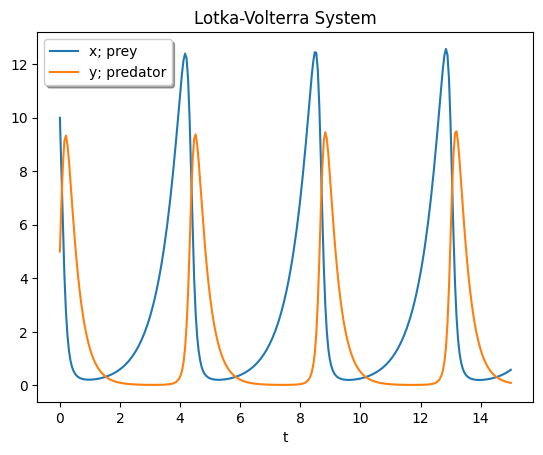

In [2]:
from scipy.integrate import solve_ivp


def lotkavolterra(t, z, a, b, c, d):
    x, y = z
    return [a * x - b * x * y, -c * y + d * x * y]


sol = solve_ivp(lotkavolterra, [0, 15], [10, 5], args=(1.5, 1, 3, 1), dense_output=True)

t = np.linspace(0, 15, 300)
z = sol.sol(t)

plt.plot(t, z.T)
plt.xlabel("t")
plt.legend(["x; prey", "y; predator"], shadow=True)
plt.title("Lotka-Volterra System")
plt.show()

---
## 積分
### scipy.integrate.quad
定積分を計算します。

>```python
>scipy.integrate.quad(func, a, b, args=(), full_output=0, epsabs=1.49e-08, epsrel=1.49e-08,\
>    limit=50, points=None, weight=None, wvar=None, wopts=None, maxp1=50, limlst=50)
>```

`y` と `abserr` を返します。
- y（float）：funcのaからbまでの定積分。
- abserr（float）：結果の絶対誤差の推定値。

次の定積分を計算しましょう：$ \int_0^4 x^2 dx$

In [3]:
x2 = lambda x: x**2
ans = integrate.quad(x2, 0, 4)  # 数値的な結果
print("x, y = ", ans)


display(Latex("$$ \int_0^4 x^2 dx = \\frac{x^3}{3} \Big|_0^4 = \\frac{4^3}{3} = 23.3333 $$"))

x, y =  (21.333333333333332, 2.3684757858670003e-13)


<IPython.core.display.Latex object>

---
## 方程式の根を求める
### scipy.optimize.root_scalar
スカラー関数の根を求めます。
>```python
>scipy.optimize.root_scalar(f, args=(), method=None, bracket=None, fprime=None, fprime2=None,\
>    x0=None, x1=None, xtol=None, rtol=None, maxiter=None, options=None)
>```

スカラー関数の根を求めます。

$$f(x) = x^2 - x -1 $$

In [4]:
from scipy import optimize


def f(x):
    return x**2 - x - 1


sol = optimize.root_scalar(f, bracket=[0, 3])  # 数値的な結果
print("numerical result: ", sol.root)


print("\nanalytical result:")
display(Latex("$$ f(x) = x^2 -x - 1 = 0 \\Longleftrightarrow x = \\frac{1 \\pm \\sqrt{5}}{2} = -0.618034, 1.618034 $$"))

numerical result:  1.618033988749895

analytical result:


<IPython.core.display.Latex object>

---
### scipy.optimize.root
ベクトル関数の根を求めます。

>```python
>scipy.optimize.root(func, x0, args=(), method='hybr', jac=None, tol=None,
>                    callback=None, options=None)
>```

In [5]:
def fun(x):
    return [x[0] + 0.5 * (x[0] - x[1]) ** 3 - 1.0, 0.5 * (x[1] - x[0]) ** 3 + x[1]]


def jac(x):  # ヤコビアン
    return np.array(
        [
            [1 + 1.5 * (x[0] - x[1]) ** 2, -1.5 * (x[0] - x[1]) ** 2],
            [-1.5 * (x[1] - x[0]) ** 2, 1 + 1.5 * (x[1] - x[0]) ** 2],
        ]
    )


sol = optimize.root(fun, [0, 0], jac=jac, method="hybr")
print('numerical result: ', sol.x)

numerical result:  [0.8411639 0.1588361]


---
### scipy.optimize.minimize
局所的な（多変数の）最適化

>```python
>scipy.optimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None,\
>    hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
>```

次の関数の最小点を求めます。

$$ f(x,y) = (1-x)^2 + 5(y-x^2)^2 $$

In [6]:
from scipy.optimize import minimize

f = lambda x: (1 - x[0]) ** 2 + 5 * (x[1] - x[0] ** 2) ** 2
x0 = [-1, -1]
res = minimize(f, x0, method="CG", options={"disp": True})
print("\nnumerical result: ", res.x)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 12
         Function evaluations: 84
         Gradient evaluations: 28

numerical result:  [0.9999993  0.99999854]


---
### scipy.optimize.least_squares
最小二乗法
>```python
>scipy.optimize.least_squares(fun, x0, jac='2-point', bounds=(- inf, inf), method='trf', ftol=1e-08,\
>    xtol=1e-08, gtol=1e-08, x_scale=1.0, loss='linear', f_scale=1.0, diff_step=None, tr_solver=None,\
>    tr_options={}, jac_sparsity=None, max_nfev=None, verbose=0, args=(), kwargs={})
>```

ここでは、フィッティング問題を解きます。


numerical result:  [3.296355   0.55072818 2.98677005]
true value:  [3, 0.5, 3]


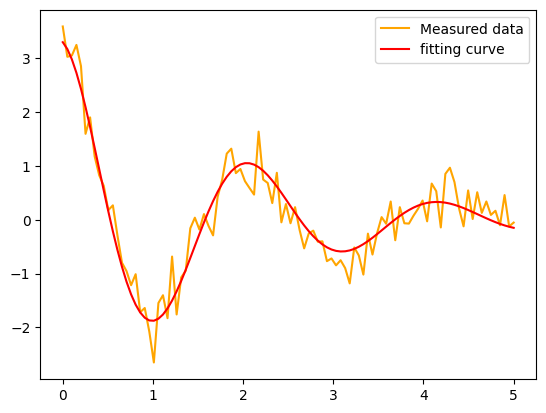

In [7]:
# 変数に制約がある非線形最小二乗法の問題を解きます。
import os
import scipy.optimize as opt

# p: パラメータ、t: 時間、y: 測定データ
fitFunc = lambda p, t: p[0] * np.exp(-p[1] * t) * np.cos(p[2] * t)
errFunc = lambda p, t, y: fitFunc(p, t) - y

np.random.seed(0)
x = np.linspace(0, 5, 100)
y = fitFunc([3, 0.5, 3], x) + np.random.randn(len(x)) / 3

p0 = [1, 1, 1]  # パラメータの初期推定値
(p, success) = opt.leastsq(errFunc, p0, args=(x, y))
print("\nnumerical result: ", p)
print("true value: ", [3, 0.5, 3])
nfit = fitFunc(p, x)

plt.plot(x, y, label="Measured data", color="orange")
plt.plot(x, nfit, label="fitting curve", color="red")
plt.legend()
plt.show()